# West Nile Virus Data Story_Capstone
https://www.kaggle.com/c/predict-west-nile-virus


In [182]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "white")
import time
import plotly
from scipy import stats 
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn import svm
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
% matplotlib inline

In [183]:
# load data 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
spray = pd.read_csv('spray.csv')
weather = pd.read_csv('weather.csv')
train_label = train['WnvPresent'] # series
# train_label = train.WnvPresent.values # get np arrays

### Process weather data

In [184]:
# https://www.kaggle.com/abhishek/predict-west-nile-virus/vote-me-up
# Drop 'CodeSum' column
weather = weather.drop('CodeSum', axis = 1)

In [185]:
# Split station 1 and 2 and join horizontally
weather_stn1 = weather[weather['Station'] == 1]
weather_stn2 = weather[weather['Station'] == 2]
weather_stn1 = weather_stn1.drop('Station', axis = 1)
weather_stn2 = weather_stn2.drop('Station', axis = 1)
weather = weather_stn1.merge(weather_stn2, on = 'Date')

In [186]:
# replace missing values and T with -1
weather = weather.replace('M', -1)
weather = weather.replace('-',-1)
weather = weather.replace('T',-1)
weather = weather.replace(' T',-1)
weather = weather.replace('  T',-1)

### Extract Zip code 

In [187]:
'''
# extract zip code from Address column and add to column 'Zipcode'
import re
def address2zip(address):
    extzip = re.match('^.*(?P<zipcode>\d{5}).*$', address)
    if extzip is None:
        zipcode = 'na'
    else:
        zipcode = extzip.groupdict()['zipcode']
    return zipcode


# add zipcode column to train dataset
def addzip2df(df):
    zipcodes =[]
    rownum = df.shape
    rownum = rownum[0]
    for i in range(0,rownum):
        add = df.iloc[i]['Address']
        z = address2zip(add)
        zipcodes.append(z)
    df['Zipcode'] = zipcodes
    return df
    
traindf = addzip2df(train)
testdf = addzip2df(test)

''';
traindf = train
testdf = test

### Extract Month and Day

In [188]:
# Do not extract year because train dataset and testset has different year values
# traindf['year'] = pd.DatetimeIndex(traindf['Date']).year
traindf['month'] = pd.DatetimeIndex(traindf['Date']).month
traindf['day'] = pd.DatetimeIndex(traindf['Date']).day
test['month'] = pd.DatetimeIndex(testdf['Date']).month
testdf['day'] = pd.DatetimeIndex(testdf['Date']).day

### Add integer latitude/longitude

In [189]:
traindf['Lat_int'] = traindf.Latitude.apply(int)
traindf['Long_int'] = traindf.Longitude.apply(int)
testdf['Lat_int'] = testdf.Latitude.apply(int)
testdf['Long_int'] = testdf.Longitude.apply(int)

### Drop columns

In [190]:
# drop redudant address info
# drop data leakage column NumMosquitos
# drop target variable
traindropcol = ['Address', 'AddressNumberAndStreet','WnvPresent','NumMosquitos']
traindf = traindf.drop(traindropcol, axis = 1)

# drop id and redudant address info
testdropcol = ['Id','Address', 'AddressNumberAndStreet']
testdf = testdf.drop(testdropcol, axis = 1)

### Merge with weather csv

In [192]:
traindfm = traindf.merge(weather, on = 'Date')
testdfm = testdf.merge(weather, on = 'Date')
traindfm = traindf.drop(['Date'], axis = 1)
testdfm = testdf.drop(['Date'], axis = 1)

In [193]:
traindfm.columns

Index([u'Species', u'Block', u'Street', u'Trap', u'Latitude', u'Longitude',
       u'AddressAccuracy', u'month', u'day', u'Lat_int', u'Long_int'],
      dtype='object')

In [194]:
print len(testdf)
print len(testdfm)

116293
116293


### Convert categorical column to dummy variables

In [195]:
col_to_dummy = ['Species','Block','Street','Trap','month']
traindfdummy = pd.get_dummies(traindfm,columns = col_to_dummy)
testdfdummy = pd.get_dummies(testdfm,columns = col_to_dummy)

In [196]:
traindfdummy.columns

Index([u'Latitude', u'Longitude', u'AddressAccuracy', u'day', u'Lat_int',
       u'Long_int', u'Species_CULEX ERRATICUS', u'Species_CULEX PIPIENS',
       u'Species_CULEX PIPIENS/RESTUANS', u'Species_CULEX RESTUANS',
       ...
       u'Trap_T237', u'Trap_T238', u'Trap_T900', u'Trap_T903', u'month_5',
       u'month_6', u'month_7', u'month_8', u'month_9', u'month_10'],
      dtype='object', length=347)

Index([u'Latitude', u'Longitude', u'AddressAccuracy', u'day', u'Lat_int',
       u'Long_int', u'Species_CULEX ERRATICUS', u'Species_CULEX PIPIENS',
       u'Species_CULEX PIPIENS/RESTUANS', u'Species_CULEX RESTUANS',
       ...
       u'Trap_T236', u'Trap_T237', u'Trap_T238', u'Trap_T900', u'Trap_T903',
       u'month_6', u'month_7', u'month_8', u'month_9', u'month_10'],
      dtype='object', length=372)

In [147]:
print len(traindfdummy)
print len(testdfdummy)

10506
116293


### Drop column with -1

In [148]:
traindfdummy = traindfdummy.ix[:, (traindfdummy !=-1).any(axis = 0)]
testdfdummy = testdfdummy.ix[:, (testdfdummy !=-1).any(axis = 0)]

In [149]:
print len(traindfdummy)
print len(testdfdummy)

10506
116293


### Check number of na values in each variables
There is no NaNs in traindfdummy 

In [150]:
x = traindfdummy.isnull().sum(axis=1).tolist()
y = float(sum(x))/(traindfdummy.shape[0]*traindfdummy.shape[1])
print 'Fraction nulls = ',y

Fraction nulls =  0.0


### Correlation between variables

In [151]:
corr = traindfdummy.corr()

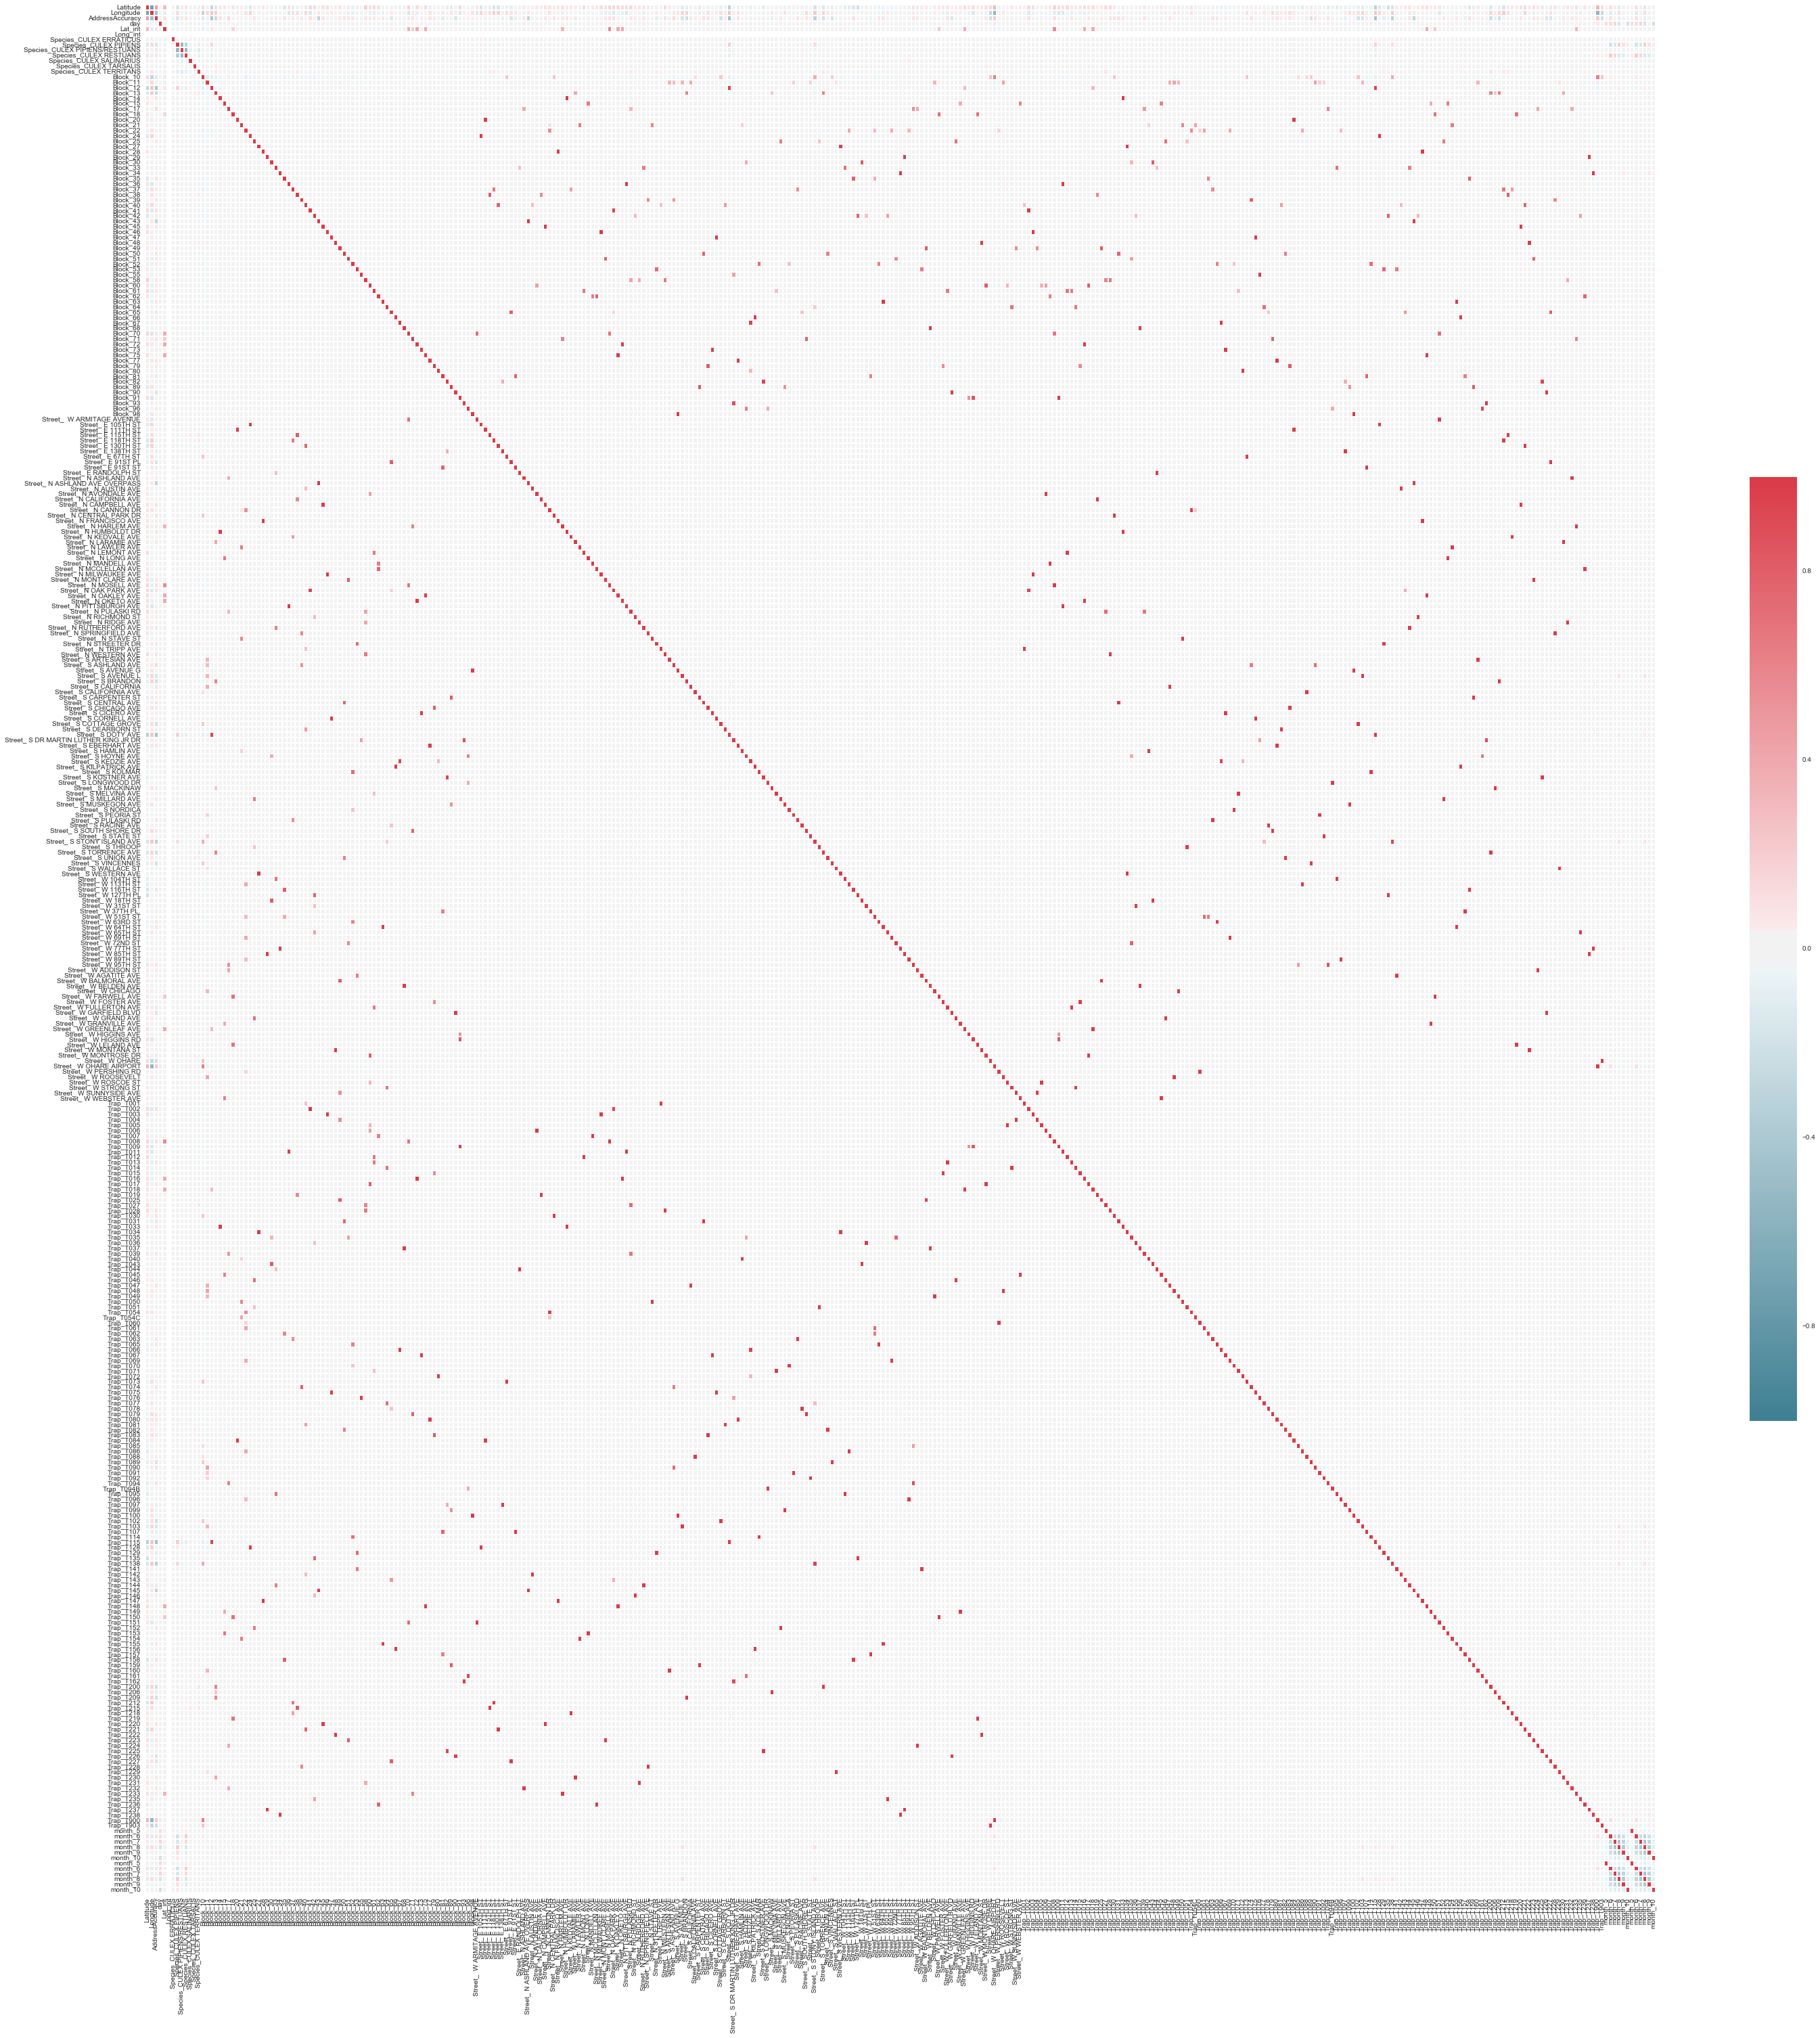

In [152]:
# correlation between numerical varialbes
fig, ax = plt.subplots(figsize = (50,50))
cmap = sns.diverging_palette(220,10,as_cmap = True)
sns.heatmap(corr, cmap = cmap, ax = ax, linewidths=1, cbar_kws ={'shrink': 0.5})
plt.show()

### Baseline

In [153]:
dfpredict = traindfdummy
dfresponse = train_label

In [154]:
# create a training and test dat set. 
X_train, X_test, y_train, y_test = train_test_split(dfpredict,dfresponse,test_size = 0.2)
print X_train.shape, X_test.shape, y_train.shape, y_test.shape
# predict all accepted
print 'Accuracy when predicting all with virus = ', metrics.accuracy_score(y_test, np.ones(y_test.shape))
# predict all rejected
print 'Accuracy when predicting all without virus = ', metrics.accuracy_score(y_test,np.zeros(y_test.shape))

(8404, 353) (2102, 353) (8404L,) (2102L,)
Accuracy when predicting all with virus =  0.0542340627973
Accuracy when predicting all without virus =  0.945765937203


### Logistic Regression

In [155]:
logStartTime = time.time()
cdict = {}
for c in [0.001,0.01,0.1,1,10,100,1000]:
    clf = linear_model.LogisticRegression(C=c)
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
    cdict[c] = scores.mean()
print cdict
best_c = max(cdict, key=cdict.get)
print 'Best parameter: ', best_c, cdict[best_c]
clflog = linear_model.LogisticRegression(C=best_c)
clflog.fit(X_train,y_train)
predicted = clflog.predict(X_test)
print 'Accuracy on test set: ',metrics.accuracy_score(y_test, predicted)
logTime = time.time() - logStartTime

{1: 0.94800110412773897, 100: 0.94788219806352969, 0.1: 0.94800110412773897, 1000: 0.94788219806352969, 10: 0.94788219806352969, 0.001: 0.94800110412773897, 0.01: 0.94800110412773897}
Best parameter:  1 0.948001104128
Accuracy on test set:  0.945765937203


Logistic Reression prediction is no better than baseline accuracy. They are exactly the same? How come?

### Random Forest

In [156]:
RanGiniStartTime = time.time()
ntdict = {}
for nt in [100,250,500,1000,2500]:
    clf = RandomForestClassifier(n_estimators=nt,criterion="gini")
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    ntdict[nt] = scores.mean()
print ntdict
best_nt = max(ntdict, key=ntdict.get)
print 'Best parameter: ',best_nt, ntdict[best_nt]
clfRF_gini = RandomForestClassifier(n_estimators=nt)
clfRF_gini.fit(X_train,y_train)
predicted = clfRF_gini.predict(X_test)
print 'Accuracy on test set: ',metrics.accuracy_score(y_test,predicted)
RanGiniTime = time.time() - RanGiniStartTime

{1000: 0.92931997055659354, 500: 0.92943859351112612, 250: 0.92884406319007984, 100: 0.92955820734952732, 2500: 0.92884448785459495}
Best parameter:  100 0.92955820735
Accuracy on test set:  0.931493815414


In [157]:
# repeat using entropy instead of gini
RanEntStartTime = time.time()
ntdict = {}
# We added 5000 because a few times, the optimal number of trees was on the edge
for nt in [250,500,1000,2500,5000]:
    clf = RandomForestClassifier(n_estimators=nt,criterion="entropy")
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    ntdict[nt] = scores.mean()
print ntdict
best_nt = max(ntdict, key=ntdict.get)
print 'Best parameter: ',best_nt, ntdict[best_nt]
clfRF_ent = RandomForestClassifier(n_estimators=nt)
clfRF_ent.fit(X_train,y_train)
predicted = clfRF_ent.predict(X_test)
print 'Accuracy on test set: ',metrics.accuracy_score(y_test,predicted)
RanEntTime = time.time() - RanEntStartTime

{1000: 0.92943887662080305, 2500: 0.92979601947794577, 250: 0.92920177226657619, 500: 0.92943915973047952, 5000: 0.92991464243247834}
Best parameter:  5000 0.929914642432
Accuracy on test set:  0.931493815414


### Decision Tree

In [158]:
TreeStartTime = time.time()
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
predicted = dt.predict(X_test)
print 'Accuracy on test test:', metrics.accuracy_score(y_test, predicted)
TreeTime = time.time() - TreeStartTime

Accuracy on test test: 0.926260704091


### K-Nearest Neighbours

In [159]:
KnnStartTime = time.time()
kdict = {}
for k in [10,15,20,25,30,35]:
    clf = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    kdict[k] = scores.mean()
print kdict
best_k = max(kdict, key=kdict.get)
print 'Best parameter: ',best_k, kdict[best_k]
clfknn = KNeighborsClassifier(n_neighbors=best_k)
clfknn.fit(X_train,y_train)
predicted = clfknn.predict(X_test)
print 'Accuracy on test set: ', metrics.accuracy_score(y_test,predicted)
KnnTime = time.time() - KnnStartTime

{35: 0.94800110412773897, 10: 0.94669143876337691, 15: 0.947287526187645, 20: 0.94788205650869151, 25: 0.94800110412773897, 30: 0.94800110412773897}
Best parameter:  35 0.948001104128
Accuracy on test set:  0.945765937203


### SVM

In [160]:
# Linear SVM
SVMStartTime = time.time()
cdict = {}
for c in [0.0001,0.001,0.01,0.1,1,10]:
    clf = svm.LinearSVC(loss="hinge",C=c);
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    cdict[c] = scores.mean()
print cdict
best_c = max(cdict, key=cdict.get)
print 'Best parameter: ', best_c, cdict[best_c]
clf = svm.LinearSVC(loss="hinge",C=best_c);
clf.fit(X_train,y_train)
predicted = clf.predict(X_test)
print 'Accuracy on test set: ',metrics.accuracy_score(y_test,predicted)
SVMTime = time.time() - SVMStartTime

{1: 0.94800110412773897, 0.1: 0.94800110412773897, 10: 0.94800110412773897, 0.001: 0.94800110412773897, 0.0001: 0.94800110412773897, 0.01: 0.94800110412773897}
Best parameter:  1 0.948001104128
Accuracy on test set:  0.945765937203


In [161]:
# Kernalized SVM
SVMKStartTime = time.time()
cdict = {}
for c in [0.001,0.01,0.1,1,10,100,1000]:
    clf = svm.SVC(C=c);
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    cdict[c] = scores.mean()
print cdict
best_c = max(cdict, key=cdict.get)
print 'Best parameter: ',best_c, cdict[best_c]
clfsvm = svm.SVC(C=best_c);
clfsvm.fit(X_train,y_train)
predicted = clfsvm.predict(X_test)
print 'Accuracy on test set: ',metrics.accuracy_score(y_test,predicted)
SVMKTime = time.time() - SVMStartTime

{1: 0.94800110412773897, 100: 0.94800110412773897, 0.1: 0.94800110412773897, 1000: 0.94788205650869128, 10: 0.94800110412773897, 0.001: 0.94800110412773897, 0.01: 0.94800110412773897}
Best parameter:  1 0.948001104128
Accuracy on test set:  0.945765937203


### Adaboost

In [162]:
AdaStartTime = time.time()
from sklearn.ensemble import AdaBoostClassifier
ndict={}
for n in [50,100,150,200,250]:
    clf = AdaBoostClassifier(n_estimators=n);
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    ndict[n] = scores.mean()
print ndict
best_n = max(ndict, key=ndict.get)
print 'Best parameter: ',best_n, ndict[best_n]
clfada = AdaBoostClassifier(n_estimators=best_n);
clfada.fit(X_train,y_train)
predicted = clfada.predict(X_test)
print 'Accuracy on test set: ', metrics.accuracy_score(y_test,predicted)
AdaTime = time.time() - AdaStartTime

{200: 0.9478819149538531, 50: 0.94788219806352969, 100: 0.94812015174678665, 250: 0.94788191495385321, 150: 0.94800110412773897}
Best parameter:  100 0.948120151747
Accuracy on test set:  0.94529019981


### ROC Curve

In [163]:
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax= None, labe = 5, proba = True, skip = 0):
    initial = False
    if not ax:
        fig,ax = plt.subplots()
        fig.set_size_inches(16,12)
        #ax = plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds = roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds = roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr,tpr)
    
    # legend
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.8, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.8, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.1,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate',fontsize = 14)
        ax.set_ylabel('True Positive Rate',fontsize = 14)
        ax.set_title('ROC',fontsize = 16)
    ax.legend(loc="lower right")
    return ax

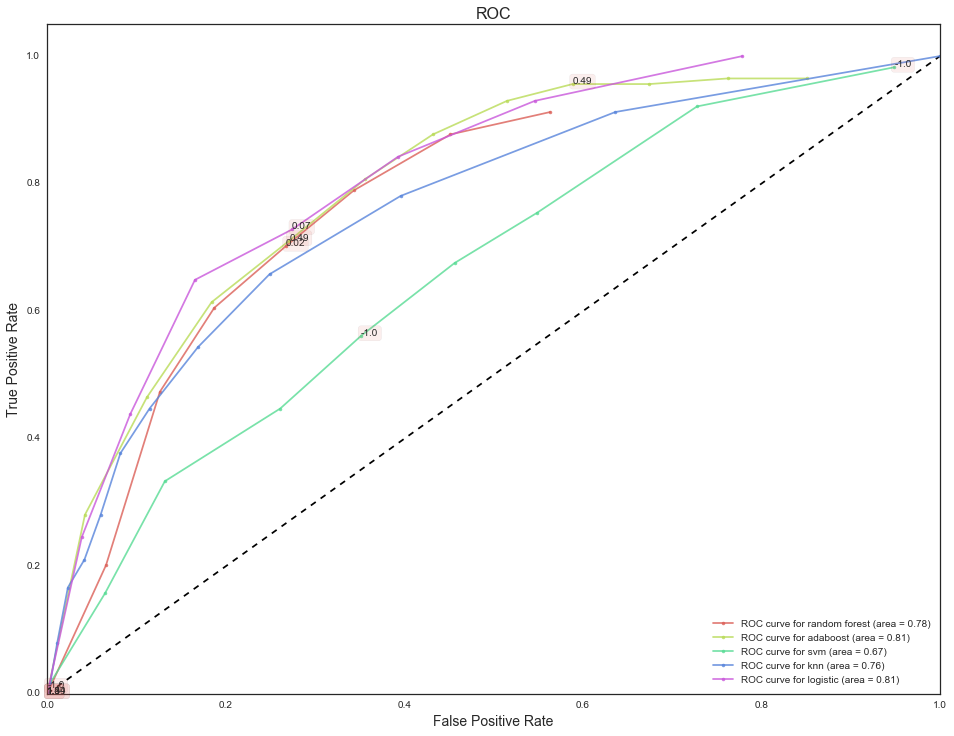

In [175]:
with sns.hls_palette(5):
    ax = make_roc("random forest", clfRF_gini, y_test,X_test,labe = 200, skip = 50, proba = True)
    make_roc("adaboost", clfada,y_test,X_test,ax=ax,labe = 200, skip = 50, proba = True)
    make_roc("svm",clfsvm,y_test,X_test,ax=ax,labe = 200,skip = 50, proba = False)
    make_roc("knn",clfknn,y_test,X_test,ax=ax,labe = 200, proba = True)
    make_roc("logistic",clflog,y_test,X_test, ax=ax, labe = 200, skip = 50, proba = True)

plt.savefig('ROC.png',dpi = 100)

### Running Time

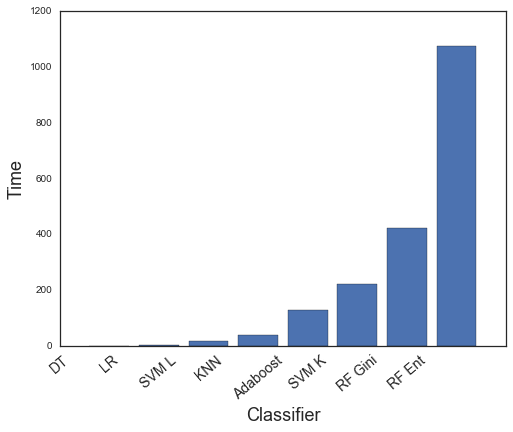

In [174]:
Times = {}
Times['LR'] = logTime
Times['RF Gini'] = RanGiniTime
Times['RF Ent'] = RanEntTime
Times['DT'] = TreeTime
Times['KNN'] = KnnTime
Times['SVM L'] = SVMTime
Times['SVM K'] = SVMKTime
Times['Adaboost'] = AdaTime

# sort dictionary
from collections import OrderedDict
sortDict = OrderedDict(sorted(Times.items(), key = lambda(k,v):(v,k)))

fig,ax = plt.subplots(figsize = (8,6))
ax.bar(range(len(sortDict)), sortDict.values(), align = 'center')
ax.set_xticks(range(len(sortDict)), sortDict.keys())
ax.set_xlabel('Classifier',fontsize = 18)
ax.set_ylabel('Time', fontsize = 18)
ax.set_xticklabels(sortDict.keys(), rotation = 40,fontsize = 14)
plt.savefig('Time.png', dpi = 100)
plt.show()


### Predicton

In [179]:
traindfdummy.columns

Index([u'Latitude', u'Longitude', u'AddressAccuracy', u'day', u'Lat_int',
       u'Long_int', u'Species_CULEX ERRATICUS', u'Species_CULEX PIPIENS',
       u'Species_CULEX PIPIENS/RESTUANS', u'Species_CULEX RESTUANS',
       ...
       u'month_7', u'month_8', u'month_9', u'month_10', u'month_5', u'month_6',
       u'month_7', u'month_8', u'month_9', u'month_10'],
      dtype='object', length=353)

In [181]:
testdfdummy.columns

Index([u'Latitude', u'Longitude', u'AddressAccuracy', u'day', u'Lat_int',
       u'Long_int', u'Species_CULEX ERRATICUS', u'Species_CULEX PIPIENS',
       u'Species_CULEX PIPIENS/RESTUANS', u'Species_CULEX RESTUANS',
       ...
       u'month_6', u'month_7', u'month_8', u'month_9', u'month_10', u'month_6',
       u'month_7', u'month_8', u'month_9', u'month_10'],
      dtype='object', length=377)

In [199]:
'''
# Use Adaboost
clf = AdaBoostClassifier(n_estimators=100);
clf.fit(traindfdummy,train_label)
predictions = clf.predict_proba(testdfdummy)[:,1]

'''
;

''